# Correlation analysis between embeddings and performance metrics

In [131]:
# import dependencies
from text_embedder import TextEmbedder
from gensim import corpora, models
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

In [133]:
# load pre-trained data
business = pd.read_csv('../data/chinese_business_clean.csv')
reviews = pd.read_csv('../data/chinese_reviews_clean_offsets.csv')

reviews['date_tuple'] = [eval(i) for i in reviews['date_tuple']]
reviews['quarter'] = [eval(i) for i in reviews['quarter']]

# load gensim model
lda =  models.LdaModel.load('../data/gensim/lda.model')
dictionary = corpora.Dictionary.load('../data/gensim/chinsese_dict.dict')

# load idf matrices
with open('../data/u_idf.pickle', 'rb') as f:
    uidf_data = pickle.load(f)
with open('../data/b_idf.pickle', 'rb') as f:
    bidf_data = pickle.load(f)

In [134]:
# initialize text embedding classs
embedder = TextEmbedder(model = lda, dictionary = dictionary, user_idf = uidf_data, business_idf = bidf_data)

In [135]:
# use top2 growing, declining business for case study
case2 = reviews[reviews['business_id'] == 'pH0BLkL4cbxKzu471VZnuA'] # growing 
case3 = reviews[reviews['business_id'] == 'X8c23dur0ll2D9XTu-I8Qg'] # declining

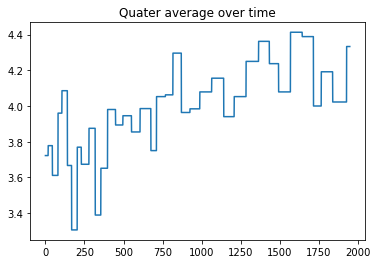

In [138]:
# case2 is growing
plt.plot(case2.sort_values(by= 'quarter')['quarter_avg'].values)
plt.title('Quater average over time')
plt.show()

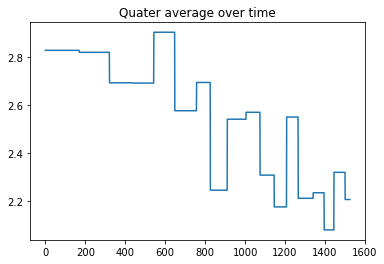

In [140]:
# case3 is declining
plt.plot(case3.sort_values(by= 'quarter')['quarter_avg'].values)
plt.title('Quater average over time')
plt.show()

## Raw value of embedded topic vs Business offset

We are going to compare the correlation between the topics and business offsets (review - business average). Offsets are different across reviews, and this metric suggests how positive/negative the topic is given the business

In [141]:
# helper to make a labels 
def mapping(x):
    if x < 0:
        return 0
    else:
        return int(x!=0)+1

In [142]:
# embedding helper class
def embed_by_enum(data, embedder, enum = 0, binary = False):
    # select regions
    if binary:
        data = data[data['business_offset'] != 0]
    label = data['business_offset']
    # create labels
    if enum == 0: 
        embed = np.array([embedder.augmented_embed_text(t) for t in data['text'].values])
    elif enum == 1: 
        embed = np.array([embedder.user_tfidf_embed(t, u) for t, u in zip(data['text'].values, data['user_id'].values)])
    elif enum == 2: 
        embed = np.array([embedder.user_tf_business_idf(t, b) for t, b in zip(data['text'].values, data['business_id'].values)])
    elif enum == 3: 
        embed = np.array([embedder.user_tfidf_business_idf(t, u, b) for t, u, b in zip(data['text'].values, data['user_id'].values, data['business_id'].values)])
    elif enum == 4: 
        embed = np.array([embedder.embed(t) for t in data['text'].values])
    elif enum == 5:
        embed = np.array([embedder.embed_sent(t) for t in data['text'].values])
    else:
        print ('enum {} is not supported'.format(enum))
        return None
    return embed, label

## Case 1 - SUSHISAMBA (growing business)

In [144]:
business[business['business_id'] == 'pH0BLkL4cbxKzu471VZnuA']

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
1499,3327 Las Vegas Blvd S,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",pH0BLkL4cbxKzu471VZnuA,"['Nightlife', 'Restaurants', 'Breakfast & Brun...",Las Vegas,"{'Monday': '11:30-1:00', 'Tuesday': '11:30-1:0...",1,36.124582,-115.167553,SUSHISAMBA - Las Vegas,The Strip,89109,1973,4.0,NV


In [145]:
# embedding 
embed, label = embed_by_enum(case2, embedder)
embed1, label1 = embed_by_enum(case2, embedder, enum = 1)
embed2, label2 = embed_by_enum(case2, embedder, enum = 2)
embed3, label3 = embed_by_enum(case2, embedder, enum = 3)
embed4, label4 = embed_by_enum(case2, embedder, enum = 4)
embed5, label5 = embed_by_enum(case2, embedder, enum = 5)

In [40]:
# print out the correlation coefficients as well as topic distribution
def find_min_max_coef(embed, label):
    coef = []
    for i in range(len(embed[0])):
        coef.append(np.corrcoef(embed[:,i], label)[0, 1])
    coef = np.array(coef)
    coef[np.isnan(coef)] = 0.0
    for i in range(3):
        print ('topic {} : {}'.format(np.argsort(coef)[i], np.sort(coef)[i]))
        print (lda.print_topic(np.argsort(coef)[i], topn=5))
    print ('\n')
    for i in range(3):
        print ('topic {} : {}'.format(np.argsort(coef)[len(coef)-1-i], np.sort(coef)[len(coef)-1-i]))
        print (lda.print_topic(np.argsort(coef)[len(coef)-1-i], topn=5))
    return np.sort(coef)[:10], np.sort(coef)[-10:]

In [56]:
_ = find_min_max_coef(embed, case2['business_offset'])

topic 117 : -0.20815932388612304
0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time"
topic 4 : -0.2069766966873559
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"
topic 79 : -0.1913239430745075
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"


topic 46 : 0.38164734766019237
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 69 : 0.12474810582142369
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"
topic 62 : 0.12171644511562767
0.014*"like" + 0.013*"good" + 0.011*"ice" + 0.011*"cream" + 0.010*"dessert"


In [57]:
_ = find_min_max_coef(embed1, case2['business_offset'])

topic 117 : -0.23904602931030047
0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time"
topic 79 : -0.18926538704869217
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 4 : -0.1723798889450011
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 46 : 0.2882341198374784
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 69 : 0.11774744892888418
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"
topic 62 : 0.10745919481873117
0.014*"like" + 0.013*"good" + 0.011*"ice" + 0.011*"cream" + 0.010*"dessert"


In [58]:
_ = find_min_max_coef(embed2, case2['business_offset'])

topic 4 : -0.20608507055822134
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"
topic 79 : -0.19521207327696227
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 117 : -0.18977537733569497
0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time"


topic 46 : 0.3928921797061257
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 69 : 0.13600956249066676
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"
topic 62 : 0.12949783750751806
0.014*"like" + 0.013*"good" + 0.011*"ice" + 0.011*"cream" + 0.010*"dessert"


In [59]:
_ = find_min_max_coef(embed3, case2['business_offset'])

topic 117 : -0.2260697529848864
0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time"
topic 79 : -0.17744711694665855
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 4 : -0.16783686539947487
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 46 : 0.2680245904935
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 69 : 0.1293433649528677
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"
topic 62 : 0.11122753683882218
0.014*"like" + 0.013*"good" + 0.011*"ice" + 0.011*"cream" + 0.010*"dessert"


In [60]:
_ = find_min_max_coef(embed4, case2['business_offset'])

topic 4 : -0.2273386670261783
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"
topic 47 : -0.200821911888756
0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated"
topic 79 : -0.19515304324968585
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"


topic 46 : 0.2930571634079916
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 62 : 0.13791437819865152
0.014*"like" + 0.013*"good" + 0.011*"ice" + 0.011*"cream" + 0.010*"dessert"
topic 69 : 0.12678599485105407
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"


In [61]:
_ = find_min_max_coef(embed5, case2['business_offset'])

topic 4 : -0.21591541626593985
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"
topic 79 : -0.20882328455882343
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 117 : -0.20816024493573337
0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time"


topic 46 : 0.3316895258311725
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 69 : 0.13028361013521256
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"
topic 62 : 0.10716644799356319
0.014*"like" + 0.013*"good" + 0.011*"ice" + 0.011*"cream" + 0.010*"dessert"


### what is this?

Each embedding is a different representation of text topics, but underlying LDA shares the common word-to-topic distribution. We are comparing the correlation between each topic and 'business-offset'. Here, business-offset is a metric of how positive/negative a given text embedding is, which means, the same exact text might have a different correlation if you are observing different business. 

Positively large correlation means that the topic is important to decide 'strength' of business. For example, from the embedding 4 and embedding 5, we can deduce that the business we are observing is known for good service, sushi and dessert. 

Negatively large correlation means that the topic is important to decide 'weakness' of business. For example, from the embedding 4 and embedding 5, we can deduce that the business we are observing is known for taking long time to bring food.

# Case2 - Hakkasan Nightclub (declining business)

In [62]:
business[business['business_id'] == 'X8c23dur0ll2D9XTu-I8Qg']

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
3489,"Mgm Grand Hotel And Casino, 3799 Las Vegas Blvd S","{'WheelchairAccessible': True, 'Alcohol': 'ful...",X8c23dur0ll2D9XTu-I8Qg,"['Dance Clubs', 'Cantonese', 'Chinese', 'Loung...",Las Vegas,"{'Sunday': '22:30-4:00', 'Friday': '22:30-4:00...",1,36.101375,-115.172452,Hakkasan Nightclub,The Strip,89109,1547,2.5,NV


In [63]:
# embed
embed, label = embed_by_enum(case3, embedder)
embed1, label1 = embed_by_enum(case3, embedder, enum = 1)
embed2, label2 = embed_by_enum(case3, embedder, enum = 2)
embed3, label3 = embed_by_enum(case3, embedder, enum = 3)
embed4, label4 = embed_by_enum(case3, embedder, enum = 4)

In [68]:
find_min_max_coef(embed, label)

topic 79 : -0.3005659169983813
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 2 : -0.23973956922882114
0.019*"time" + 0.013*"food" + 0.013*"card" + 0.009*"good" + 0.009*"service"
topic 117 : -0.18542824221630655
0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time"


topic 46 : 0.29739388451174054
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 40 : 0.21159050776662425
0.014*"dish" + 0.013*"fried" + 0.013*"chinese" + 0.011*"good" + 0.011*"food"
topic 75 : 0.19631950672771128
0.032*"pork" + 0.027*"noodles" + 0.018*"beef" + 0.018*"soup" + 0.016*"noodle"


(array([-0.30056592, -0.23973957, -0.18542824, -0.17951682, -0.12071189,
        -0.072173  , -0.06277756, -0.06011919, -0.05947365, -0.04731726]),
 array([ 0.11129294,  0.11223196,  0.1123022 ,  0.11838173,  0.13385503,
         0.15279812,  0.1728636 ,  0.19631951,  0.21159051,  0.29739388]))

In [69]:
find_min_max_coef(embed1, label1)

topic 79 : -0.2867604686465716
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 117 : -0.20537251475483817
0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time"
topic 4 : -0.2031712205707229
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 46 : 0.3281465944604852
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 69 : 0.10349486377839956
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"
topic 13 : 0.08806381817992032
0.072*"food" + 0.046*"chinese" + 0.029*"good" + 0.027*"place" + 0.015*"ve"


(array([-0.28676047, -0.20537251, -0.20317122, -0.17445709, -0.13730759,
        -0.07867283, -0.07349005, -0.0719741 , -0.06255625, -0.06181086]),
 array([ 0.07493478,  0.07524254,  0.07967367,  0.08046776,  0.08554775,
         0.08561394,  0.08600264,  0.08806382,  0.10349486,  0.32814659]))

In [70]:
find_min_max_coef(embed2, label2)

topic 79 : -0.29089675448282715
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 2 : -0.24015426474648432
0.019*"time" + 0.013*"food" + 0.013*"card" + 0.009*"good" + 0.009*"service"
topic 4 : -0.1920034841246917
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 46 : 0.29422849180307453
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 40 : 0.22389248788147995
0.014*"dish" + 0.013*"fried" + 0.013*"chinese" + 0.011*"good" + 0.011*"food"
topic 104 : 0.15388349752126923
0.019*"tofu" + 0.016*"good" + 0.011*"food" + 0.011*"sauce" + 0.011*"dish"


(array([-0.29089675, -0.24015426, -0.19200348, -0.19008145, -0.13035712,
        -0.08272838, -0.06915906, -0.06392164, -0.06260369, -0.05783434]),
 array([ 0.09513473,  0.10011498,  0.10221595,  0.11730562,  0.12597131,
         0.12617033,  0.14330541,  0.1538835 ,  0.22389249,  0.29422849]))

In [71]:
find_min_max_coef(embed3, label3)

topic 79 : -0.273907277071434
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 117 : -0.204483344707044
0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time"
topic 4 : -0.19876466566238832
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 46 : 0.3129906811421479
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 69 : 0.10071527594326254
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"
topic 13 : 0.08555884748331102
0.072*"food" + 0.046*"chinese" + 0.029*"good" + 0.027*"place" + 0.015*"ve"


(array([-0.27390728, -0.20448334, -0.19876467, -0.16114561, -0.13597406,
        -0.08257218, -0.07735134, -0.07240232, -0.06648489, -0.0637637 ]),
 array([ 0.06534654,  0.06986466,  0.07523922,  0.07758658,  0.08243998,
         0.08328901,  0.08380059,  0.08555885,  0.10071528,  0.31299068]))

In [72]:
find_min_max_coef(embed4, label4)

/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


topic 79 : -0.2831901096086113
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 2 : -0.22426953515736192
0.019*"time" + 0.013*"food" + 0.013*"card" + 0.009*"good" + 0.009*"service"
topic 4 : -0.16638773646117916
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 29 : 0.3183769211900684
0.016*"club" + 0.015*"place" + 0.011*"like" + 0.011*"floor" + 0.011*"great"
topic 46 : 0.1948110736529799
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 69 : 0.08358058173499343
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"


(array([-0.28319011, -0.22426954, -0.16638774, -0.09254746, -0.07885824,
        -0.06824697, -0.05458061, -0.04771297, -0.04742749, -0.04714307]),
 array([ 0.04272069,  0.04291051,  0.04500626,  0.04588591,  0.05394757,
         0.07747799,  0.08285236,  0.08358058,  0.19481107,  0.31837692]))

In [73]:
find_min_max_coef(embed5, label5)

topic 4 : -0.17814022624348053
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"
topic 124 : -0.14966446739493958
0.071*"sushi" + 0.014*"food" + 0.013*"roll" + 0.011*"buffet" + 0.010*"time"
topic 47 : -0.14198065648147
0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated"


topic 46 : 0.34782694731463
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 69 : 0.09878894408155195
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"
topic 121 : 0.06568858341087269
0.036*"food" + 0.026*"service" + 0.020*"great" + 0.016*"lunch" + 0.014*"good"


(array([-0.17814023, -0.14966447, -0.14198066, -0.14063779, -0.13337645,
        -0.12582145, -0.09291071, -0.09057439, -0.08974801, -0.08934017]),
 array([ 0.04996391,  0.05769427,  0.05782128,  0.05994184,  0.06173495,
         0.06404216,  0.06559491,  0.06568858,  0.09878894,  0.34782695]))

### What is this

Something I realize is some topics such as Topic 4, topic 117 are recurrently appearing across businesses. This means the negative topics failed to generalize business specific information, but rather, making an observation of tendency that people conplain more about time when it comes to chinese restaurants

# Preliminary time-series analysis

We are going to compare the correlation between the *slope* of topics in a quarter and quarter offsets (quarter average - business average). Positive correlation means topics that the business wants the users to talk more in order to improve the business

In [74]:
def embed_by_enum(data, embedder, enum = 0, binary = False):
    # select regions
    if binary:
        data = data[data['quater_offset'] != 0]
    label = data['quater_offset']
    # create labels
    if enum == 0: 
        embed = np.array([embedder.augmented_embed_text(t) for t in data['text'].values])
    elif enum == 1: 
        embed = np.array([embedder.user_tfidf_embed(t, u) for t, u in zip(data['text'].values, data['user_id'].values)])
    elif enum == 2: 
        embed = np.array([embedder.user_tf_business_idf(t, b) for t, b in zip(data['text'].values, data['business_id'].values)])
    elif enum == 3: 
        embed = np.array([embedder.user_tfidf_business_idf(t, u, b) for t, u, b in zip(data['text'].values, data['user_id'].values, data['business_id'].values)])
    elif enum == 4: 
        embed = np.array([embedder.embed(t) for t in data['text'].values])
    elif enum == 5:
        embed = np.array([embedder.embed_sent(t) for t in data['text'].values])
    else:
        print ('enum {} is not supported'.format(enum))
        return None
    return embed, label

In [152]:
# helper to build sequential data, fitting a linear regression and taking a slope
# on a side note, I also tried with SVR but the line of best fit tends to be horizontal, aka simply finding the average
def build_data(df, enum):
    qs = sorted(list(set(df['quarter'])))
    X = []
    y = []
    for q in qs:
        filtered = df[df['quarter'] == q]
        embed, labels = embed_by_enum(filtered, embedder, enum)
        
        # fit on the sequence, store the slope
        regr = LinearRegression()
        regr.fit(np.arange(len(embed)).reshape(-1,1),embed)
        X.append(regr.coef_.reshape(1,-1)[0])
        
        y.append(list(set(filtered['quarter_avg'].values))[0])
    return np.array(X), np.array(y)

## Case 1 - SUSHISAMBA (growing business)

In [154]:
# embed (this takes longer)
%time x,y = build_data(case2, 0)
%time x1,y1 = build_data(case2, 1)
%time x2,y2 = build_data(case2, 2)
%time x3,y3 = build_data(case2, 3)
%time x4,y4 = build_data(case2, 4)
%time x5,y5 = build_data(case2, 5)

CPU times: user 51.6 s, sys: 573 ms, total: 52.2 s
Wall time: 28.2 s
CPU times: user 52.4 s, sys: 552 ms, total: 53 s
Wall time: 28.2 s
CPU times: user 52.7 s, sys: 654 ms, total: 53.3 s
Wall time: 28.6 s
CPU times: user 52.1 s, sys: 547 ms, total: 52.6 s
Wall time: 28 s
CPU times: user 22.2 s, sys: 256 ms, total: 22.5 s
Wall time: 5.64 s
CPU times: user 51 s, sys: 406 ms, total: 51.4 s
Wall time: 26.6 s


In [114]:
_ = find_min_max_coef(x, y - case2['business_stars'].values[0])

topic 106 : -0.44721182359282197
0.034*"chicken" + 0.019*"rice" + 0.015*"food" + 0.014*"noodles" + 0.010*"good"
topic 47 : -0.4324429700073291
0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated"
topic 107 : -0.41196925215970903
0.018*"food" + 0.012*"good" + 0.011*"time" + 0.009*"chinese" + 0.008*"chicken"


topic 124 : 0.37710069175467564
0.071*"sushi" + 0.014*"food" + 0.013*"roll" + 0.011*"buffet" + 0.010*"time"
topic 14 : 0.369878192118161
0.021*"kim" + 0.019*"place" + 0.015*"long" + 0.014*"best" + 0.014*"food"
topic 69 : 0.3661041908792953
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"


In [113]:
_ = find_min_max_coef(x1, y1 - case2['business_stars'].values[0])

topic 47 : -0.5523757267032224
0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated"
topic 107 : -0.46342032351475654
0.018*"food" + 0.012*"good" + 0.011*"time" + 0.009*"chinese" + 0.008*"chicken"
topic 103 : -0.4405286031014295
0.045*"panda" + 0.038*"express" + 0.032*"food" + 0.016*"chinese" + 0.013*"korean"


topic 16 : 0.43054064440046996
0.028*"food" + 0.016*"good" + 0.014*"gluten" + 0.011*"free" + 0.010*"rice"
topic 69 : 0.4245056118502076
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"
topic 74 : 0.32203134780895587
0.028*"food" + 0.024*"place" + 0.014*"good" + 0.011*"time" + 0.010*"service"


In [110]:
_ = find_min_max_coef(x2, y2 - case2['business_stars'].values[0])

topic 119 : -0.4638370797298328
0.023*"food" + 0.016*"place" + 0.012*"time" + 0.011*"good" + 0.010*"great"
topic 47 : -0.40892885168277254
0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated"
topic 107 : -0.3995371499665611
0.018*"food" + 0.012*"good" + 0.011*"time" + 0.009*"chinese" + 0.008*"chicken"


topic 124 : 0.42865650910335895
0.071*"sushi" + 0.014*"food" + 0.013*"roll" + 0.011*"buffet" + 0.010*"time"
topic 127 : 0.37046448694189654
0.030*"food" + 0.016*"chinese" + 0.016*"place" + 0.011*"good" + 0.010*"service"
topic 16 : 0.3619998243094919
0.028*"food" + 0.016*"good" + 0.014*"gluten" + 0.011*"free" + 0.010*"rice"


In [111]:
_ = find_min_max_coef(x3, y3 - case2['business_stars'].values[0])

topic 47 : -0.4997467686564974
0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated"
topic 107 : -0.47247495962981345
0.018*"food" + 0.012*"good" + 0.011*"time" + 0.009*"chinese" + 0.008*"chicken"
topic 103 : -0.440948398430864
0.045*"panda" + 0.038*"express" + 0.032*"food" + 0.016*"chinese" + 0.013*"korean"


topic 16 : 0.4458457686264717
0.028*"food" + 0.016*"good" + 0.014*"gluten" + 0.011*"free" + 0.010*"rice"
topic 69 : 0.42781243414655373
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"
topic 70 : 0.3201365678945186
0.014*"place" + 0.014*"food" + 0.012*"dinner" + 0.010*"good" + 0.008*"chicken"


In [107]:
_ = find_min_max_coef(x4, y4 - case2['business_stars'].values[0])

topic 23 : -0.5829757439720386
0.038*"food" + 0.032*"place" + 0.021*"chinese" + 0.018*"great" + 0.016*"good"
topic 21 : -0.5635122761355228
0.088*"dim" + 0.087*"sum" + 0.018*"good" + 0.015*"food" + 0.014*"place"
topic 2 : -0.43490178159201165
0.019*"time" + 0.013*"food" + 0.013*"card" + 0.009*"good" + 0.009*"service"


topic 51 : 0.4169445450954524
0.016*"place" + 0.014*"good" + 0.012*"like" + 0.011*"chinese" + 0.010*"soup"
topic 14 : 0.4049832906486618
0.021*"kim" + 0.019*"place" + 0.015*"long" + 0.014*"best" + 0.014*"food"
topic 56 : 0.3749274740433533
0.018*"dim" + 0.018*"sum" + 0.015*"place" + 0.013*"good" + 0.010*"pork"


In [105]:
_ = find_min_max_coef(x5, y5 - case2['business_stars'].values[0])

topic 107 : -0.43510891830704695
0.018*"food" + 0.012*"good" + 0.011*"time" + 0.009*"chinese" + 0.008*"chicken"
topic 89 : -0.4272217163821538
0.095*"thai" + 0.051*"pad" + 0.016*"food" + 0.015*"place" + 0.012*"order"
topic 47 : -0.42300939537589105
0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated"


topic 51 : 0.4305604729343694
0.016*"place" + 0.014*"good" + 0.012*"like" + 0.011*"chinese" + 0.010*"soup"
topic 124 : 0.37379898477414564
0.071*"sushi" + 0.014*"food" + 0.013*"roll" + 0.011*"buffet" + 0.010*"time"
topic 16 : 0.3373178104693275
0.028*"food" + 0.016*"good" + 0.014*"gluten" + 0.011*"free" + 0.010*"rice"


### What is this ?

Now our observation is split by quarters (3 month period). For each quarter, we have an average rating for this period and an offset from the particular business rating. This metric represents how successful the given time period was. We are now, observing the sequence of latent topic embeddings and see if we can find any correlations between success of business over time. As a baseline analysis, I apply linear regression and compare the correlation between the coefficient of each topic (slope) and overall success of the quater. 

First of all, each topic has much greater correlation than I saw with earlier experiments. This means the sequence of topics have more significant meaning than the raw value of embedding itself. We can later validate which embedding is the best one by giving the classification task. 

Next, the results suggest the growth of some topics are highly correlated with the growth of business. Intuitively those topics are area the business should focus on more to improve their business. Some interesting topic that I observe across different embeddings are topic 16, which contains the word, 'gluten free'.

Finally, the negative correlation means the topic which might hurt the business, if they focus on. Something I see particularly is topic 47 which is about 'serving time'. But this could also mean, 47 is inheritantly a complaint about bad serving time, and decrease in this topic could suggest their improvement in the serving time.

In [123]:
# embed (this takes longer)
%time x,y = build_data(case3, 0)
%time x1,y1 = build_data(case3, 1)
%time x2,y2 = build_data(case3, 2)
%time x3,y3 = build_data(case3, 3)
%time x4,y4 = build_data(case3, 4)
%time x5,y5 = build_data(case3, 5)

CPU times: user 38.7 s, sys: 505 ms, total: 39.2 s
Wall time: 26.5 s
CPU times: user 39.2 s, sys: 380 ms, total: 39.6 s
Wall time: 26.2 s
CPU times: user 38.4 s, sys: 285 ms, total: 38.7 s
Wall time: 25.2 s
CPU times: user 39.1 s, sys: 392 ms, total: 39.5 s
Wall time: 26.1 s
CPU times: user 15.6 s, sys: 202 ms, total: 15.8 s
Wall time: 3.97 s
CPU times: user 37.7 s, sys: 261 ms, total: 37.9 s
Wall time: 24.4 s


In [124]:
_ = find_min_max_coef(x, y - case3['business_stars'].values[0])

topic 95 : -0.7069908129665764
0.024*"food" + 0.016*"chicken" + 0.013*"rice" + 0.013*"chinese" + 0.012*"chino"
topic 72 : -0.6542890727417674
0.012*"good" + 0.009*"like" + 0.007*"service" + 0.006*"restaurant" + 0.006*"table"
topic 16 : -0.5552805224807138
0.028*"food" + 0.016*"good" + 0.014*"gluten" + 0.011*"free" + 0.010*"rice"


topic 12 : 0.5821851272351886
0.064*"duck" + 0.025*"food" + 0.021*"roast" + 0.014*"chinese" + 0.013*"place"
topic 66 : 0.4687968367098695
0.019*"good" + 0.011*"time" + 0.010*"food" + 0.008*"beef" + 0.008*"like"
topic 115 : 0.4542329458202448
0.011*"food" + 0.010*"pork" + 0.008*"vegan" + 0.008*"restaurant" + 0.008*"service"


In [125]:
_ = find_min_max_coef(x1, y1 - case3['business_stars'].values[0])

topic 72 : -0.6202206799600182
0.012*"good" + 0.009*"like" + 0.007*"service" + 0.006*"restaurant" + 0.006*"table"
topic 74 : -0.5190550846571023
0.028*"food" + 0.024*"place" + 0.014*"good" + 0.011*"time" + 0.010*"service"
topic 4 : -0.4674513998514663
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 0 : 0.5129005813376062
0.023*"chop" + 0.019*"food" + 0.017*"good" + 0.012*"service" + 0.012*"chicken"
topic 115 : 0.4688964956161904
0.011*"food" + 0.010*"pork" + 0.008*"vegan" + 0.008*"restaurant" + 0.008*"service"
topic 66 : 0.4653133558383544
0.019*"good" + 0.011*"time" + 0.010*"food" + 0.008*"beef" + 0.008*"like"


In [126]:
_ = find_min_max_coef(x2, y2 - case3['business_stars'].values[0])

topic 72 : -0.5768177494196415
0.012*"good" + 0.009*"like" + 0.007*"service" + 0.006*"restaurant" + 0.006*"table"
topic 95 : -0.5071066976639753
0.024*"food" + 0.016*"chicken" + 0.013*"rice" + 0.013*"chinese" + 0.012*"chino"
topic 99 : -0.4882941835486646
0.019*"food" + 0.015*"place" + 0.014*"good" + 0.010*"like" + 0.006*"sauce"


topic 32 : 0.5454499093364636
0.033*"food" + 0.029*"delivery" + 0.016*"ordered" + 0.015*"chicken" + 0.015*"order"
topic 66 : 0.540696356530869
0.019*"good" + 0.011*"time" + 0.010*"food" + 0.008*"beef" + 0.008*"like"
topic 115 : 0.5079143261822534
0.011*"food" + 0.010*"pork" + 0.008*"vegan" + 0.008*"restaurant" + 0.008*"service"


In [127]:
_ = find_min_max_coef(x3, y3 - case3['business_stars'].values[0])

topic 72 : -0.6388310273701875
0.012*"good" + 0.009*"like" + 0.007*"service" + 0.006*"restaurant" + 0.006*"table"
topic 74 : -0.5154552516742741
0.028*"food" + 0.024*"place" + 0.014*"good" + 0.011*"time" + 0.010*"service"
topic 4 : -0.47030430355678965
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 0 : 0.5093238348251348
0.023*"chop" + 0.019*"food" + 0.017*"good" + 0.012*"service" + 0.012*"chicken"
topic 115 : 0.4881937884576402
0.011*"food" + 0.010*"pork" + 0.008*"vegan" + 0.008*"restaurant" + 0.008*"service"
topic 66 : 0.41503233391409955
0.019*"good" + 0.011*"time" + 0.010*"food" + 0.008*"beef" + 0.008*"like"


In [128]:
_ = find_min_max_coef(x4, y4 - case3['business_stars'].values[0])

/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


topic 72 : -0.5721806123247455
0.012*"good" + 0.009*"like" + 0.007*"service" + 0.006*"restaurant" + 0.006*"table"
topic 95 : -0.49597003824152397
0.024*"food" + 0.016*"chicken" + 0.013*"rice" + 0.013*"chinese" + 0.012*"chino"
topic 101 : -0.47903373080097544
0.028*"food" + 0.020*"place" + 0.016*"good" + 0.015*"service" + 0.010*"family"


topic 3 : 0.5374261798773677
0.019*"food" + 0.019*"place" + 0.011*"good" + 0.009*"ordered" + 0.009*"service"
topic 21 : 0.4619197118523889
0.088*"dim" + 0.087*"sum" + 0.018*"good" + 0.015*"food" + 0.014*"place"
topic 54 : 0.43488586621633013
0.034*"food" + 0.015*"place" + 0.010*"service" + 0.010*"good" + 0.008*"worth"


In [129]:
_ = find_min_max_coef(x5, y5 - case3['business_stars'].values[0])

topic 72 : -0.7566412672440375
0.012*"good" + 0.009*"like" + 0.007*"service" + 0.006*"restaurant" + 0.006*"table"
topic 6 : -0.46131886978053893
0.027*"food" + 0.014*"service" + 0.014*"good" + 0.013*"great" + 0.012*"place"
topic 26 : -0.433111494214208
0.015*"food" + 0.014*"nice" + 0.012*"restaurant" + 0.011*"time" + 0.010*"ramen"


topic 32 : 0.6041310241198334
0.033*"food" + 0.029*"delivery" + 0.016*"ordered" + 0.015*"chicken" + 0.015*"order"
topic 12 : 0.566144565030324
0.064*"duck" + 0.025*"food" + 0.021*"roast" + 0.014*"chinese" + 0.013*"place"
topic 124 : 0.5469508082822829
0.071*"sushi" + 0.014*"food" + 0.013*"roll" + 0.011*"buffet" + 0.010*"time"


### What is this

Something very imteresting here is the result seems completely different across businesses. For example, positive topics here incluse many food related vocabulary such as 'pork', 'duck', and 'roast'. This suggests that the business does best when their food is popular. 

### Footnote

In [174]:
# here are some example of slope
qs = sorted(list(set(case2['quarter'])))
filtered = case2[case2['quarter'] == qs[0]]
embed, labels =  embed_by_enum(filtered, embedder, 2)


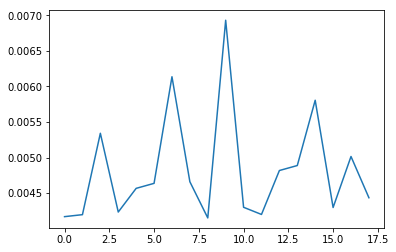

In [176]:
# positive : topic 124
plt.plot(embed[:,124])
plt.show()

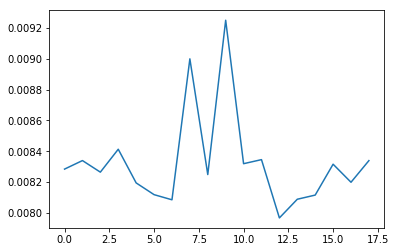

In [177]:
# positive : topic 119
plt.plot(embed[:,119])
plt.show()